<div align=center>

<p></p>
<p></p>
<font size=5>
In the Name of God
<font/>
<p></p>
 <br/>
    <br/>
<font color=#4d7db8>
Sharif University of Technology - Department of Electrical Engineering
</font>
<p></p>
<font color=#4d7db8>
Introduction To Machine Learning - Dr. Sajjad Amini
</font>
<br/>
<br/>
Spring Semester 1401-02

<div/>

<hr/>
		<div align=center>
		    <font color=red size=6>
			    <br />
        Project - 3rd Phase
        <br />
        Image Colorization using Autoencoder
			</font>
    <br/>
<font size=4>
			<br/><br/>
Due on Tir 10th
                <br/><b>
              Cheating is Strongly Prohibited
                </b><br/><br/>
                <font color=green>
Should you have any questions concerning the project, please feel free to ask via Telegram.
     </font>
</font>
                <br/>
    </div>

# Personal Info
<hr/>
    <div class="column" align=center>
    <font size=4>
        <div class="column">
        <br />
            student_number = 400109479
            <br />
            Name = MohammadPouya  
            <br />
            Last_Name = Toroghi
        </div>
        <div class="column">
        <br />
            student_number = 99102456
            <br />
            Name = Ilia
            <br />
            Last_Name = Hashemi Rad
        </div>
    </font>
    </div>


1. Download the "landscape image colorization" dataset and slice it to `train_set`, `validation_set` and `test_set`.
2. Design and train an AutoEncoder using `PyTorch` (not `TensorFlow`) on the dataset to colorize grayscale images
3. plot learning curve and visualize grayscale images of test set, their corresponding color images and their colorized versions side by side.

# Import Necessary Libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import cv2
import os
from torchvision import transforms
from torch.nn import functional as F
from skimage import io
from sklearn.model_selection import train_test_split
import keras
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

# Load Dataset and Prepare It

Downloading and unzipping the dataset:

In [2]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"oopproject12","key":"a48677dab0772d5d3d1255104cd72ae9"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d theblackmamba31/landscape-image-colorization
! unzip /content/landscape-image-colorization.zip

Streaming output truncated to the last 5000 lines.
  inflating: landscape Images/gray/2914.jpg  
  inflating: landscape Images/gray/2915.jpg  
  inflating: landscape Images/gray/2916.jpg  
  inflating: landscape Images/gray/2917.jpg  
  inflating: landscape Images/gray/2918.jpg  
  inflating: landscape Images/gray/2919.jpg  
  inflating: landscape Images/gray/292.jpg  
  inflating: landscape Images/gray/2920.jpg  
  inflating: landscape Images/gray/2921.jpg  
  inflating: landscape Images/gray/2922.jpg  
  inflating: landscape Images/gray/2923.jpg  
  inflating: landscape Images/gray/2924.jpg  
  inflating: landscape Images/gray/2925.jpg  
  inflating: landscape Images/gray/2926.jpg  
  inflating: landscape Images/gray/2927.jpg  
  inflating: landscape Images/gray/2928.jpg  
  inflating: landscape Images/gray/2929.jpg  
  inflating: landscape Images/gray/293.jpg  
  inflating: landscape Images/gray/2930.jpg  
  inflating: landscape Images/gray/2931.jpg  
  inflating: landscape Images/g

Loading the dataset into gray_images and color images: (Keep in mind that we first normalize all the pixels of image to be in the interval [0,1])

In [15]:
convert_tensor = transforms.ToTensor()
image_size = (150, 150)
color_images = []
path = 'landscape Images/color'
files = os.listdir(path)
for i in tqdm(files):
        img = cv2.imread(path + '/'+i,1)
        # Open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Resizing image
        img = cv2.resize(img, image_size)
        img = img.astype('float32') / 255.0
        color_images.append(convert_tensor(img))

gray_images = []
path = 'landscape Images/gray'
files = os.listdir(path)
for i in tqdm(files):
        img = cv2.imread(path + '/'+i,1)
        # Resizing image
        img = cv2.resize(img, image_size)
        img = img.astype('float32') / 255.0
        gray_images.append(convert_tensor(img))

100%|██████████| 7129/7129 [00:03<00:00, 1812.37it/s]


Splitting the dataset into test, train and validation sets:

In [50]:
train_size = 0.6
test_size = 0.2
validation_size = 0.2
x, x_test, y, y_test = train_test_split(gray_images,color_images,test_size=test_size,train_size=1-test_size,shuffle=True)
x_train, x_cv, y_train, y_cv = train_test_split(x,y,test_size = validation_size/(1-test_size),train_size = train_size/(1-test_size),shuffle=True)

Use data augmentation on the train set: (Adding some different version of some of the images of train dataset to the set)

In [12]:
# Defining the data augmentation transformations
transform_aug = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(size=(150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()#,transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Applying data augmentation to each sample
for i in range(len(x_train)//2):
    image = x_train[i]
    label = y_train[i]

    augmented_image = transform_aug(image)
    x_train.append(augmented_image)
    y_train.append(label)

Convert our sets to valid Pytorch datasets:

In [49]:
class CustomDataset(Dataset):
    def __init__(self, x_train, y_train):
        self.x_train = x_train
        self.y_train = y_train

    def __len__(self):
        return len(self.x_train)

    def __getitem__(self, idx):
        x = self.x_train[idx]
        y = self.y_train[idx]
        return x, y
dataset = CustomDataset(x_train, y_train)
test_set = CustomDataset(x_test, y_test)
val_set = CustomDataset(x_cv, y_cv)

# Define Your Model

Because each pixel of the images were normalized to be in the interval [0,1], we can now use the Sigmoid function in the last node, which improves our model's performance)

In [22]:
class ColorizationModel(nn.Module):
    def __init__(self, dropout_rate=0.1):
        super(ColorizationModel, self).__init__()
        # Encoder (downsampling) layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # (64, 150, 150)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # (128, 150, 150)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (128, 75, 75)
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # (256, 75, 75)
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (256, 37, 37)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # (128, 74, 74)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=0, output_padding=1),  # (64, 150, 150)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),  # (32, 150, 150)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),  # (3, 150, 150)
            nn.Sigmoid(),
        )
        # This was implemented just in case to help us with over-fitting!
        self.dropout = nn.Dropout2d(p=dropout_rate)

    def forward(self, x):
        x = self.encoder(x)  # Encode: (256, 37, 37)
        x = self.decoder(x)  # Decode: (3, 150, 150)
        #x = self.dropout(x)
        return x

# Fit The Model

Also Define optimizer, Criterion and other parameters

In [36]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)

# Model Initialization
model = ColorizationModel().to(device)

# Validation using MSE and/or L1 Loss function(s)
loss1 = nn.MSELoss()
loss2 = nn.L1Loss()

# Optimizer definition
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-2)

# Set the number of epochs and batch size
num_epochs = 10
batch_size = 10

# Create DataLoader for training dataset
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataiter = iter(train_dataloader)


val_batch_size=8
val_dataloader = DataLoader(val_set, batch_size=val_batch_size, shuffle=True)

train_loss=[]
val_loss=[]
temp=10000
# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    val_l = 0.0
    for i, (inputs, targets) in enumerate(train_dataloader):

        inputs = inputs.to(device)

        targets = targets.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        # Calculate loss
        loss_1 = loss1(outputs, targets)
        loss_2 = loss2(outputs, targets)
        loss=loss_1+loss_2

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()
    for i, (inputs, targets) in enumerate(val_dataloader):
        with torch.no_grad():
            inputs_val = inputs.to(device)#.reshape(-1,150*150)
            targets_val = targets.to(device)
            # Forward pass
            outputs_val = model(inputs_val)

            # Calculate loss
            newloss_1=loss1(outputs_val, targets_val)
            newloss_2=loss2(outputs_val, targets_val)
            newloss=newloss_1+newloss_2

            # Update running loss
            val_l+=newloss.item()

    # Calculate average train loss for the epoch
    average_loss = running_loss / len(train_dataloader)
    train_loss.append(average_loss)
    # Calculate average validation loss for the epoch
    ave_loss_val = val_l / len(val_dataloader)
    val_loss.append(ave_loss_val)

    # Saving the model with ther least validation loss
    if(ave_loss_val<temp):
      torch.save(model.state_dict(), "BestValidationLoss_model.pth")
      temp=ave_loss_val

    # Print epoch information
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {ave_loss_val:.4f}")

# Save the trained model
torch.save(model.state_dict(), f"Aug_model_epoch{num_epochs}.pth")

cuda
Epoch [1/10], Loss: 0.1259
Epoch [1/10], Validation Loss: 0.1135
Epoch [2/10], Loss: 0.1078
Epoch [2/10], Validation Loss: 0.1025
Epoch [3/10], Loss: 0.0937
Epoch [3/10], Validation Loss: 0.0874
Epoch [4/10], Loss: 0.0869
Epoch [4/10], Validation Loss: 0.0867
Epoch [5/10], Loss: 0.0813
Epoch [5/10], Validation Loss: 0.0836
Epoch [6/10], Loss: 0.0789
Epoch [6/10], Validation Loss: 0.0757
Epoch [7/10], Loss: 0.0760
Epoch [7/10], Validation Loss: 0.0748
Epoch [8/10], Loss: 0.0741
Epoch [8/10], Validation Loss: 0.0727
Epoch [9/10], Loss: 0.0735
Epoch [9/10], Validation Loss: 0.0719
Epoch [10/10], Loss: 0.0712
Epoch [10/10], Validation Loss: 0.0728


The reason that in the numbers above, the validation loss seems to be less than the train loss, is that these numbers are actually from different epochs, so the validation loss is calculated after the model's update but the train loss was calculated whilst the model was being updated.

# Plot The Results

Plotting the learning curve:

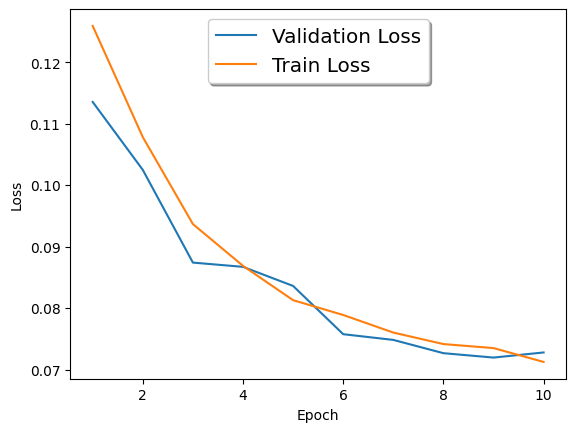

In [48]:
import matplotlib.pyplot as plt

epochs=range(1,11)
plt.plot(epochs,np.array(val_loss),label="Validation Loss")
plt.plot(epochs,np.array(train_loss),label="Train Loss")

legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
legend.get_frame()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

This function plot the color, grayscale, and colorized images:

In [33]:
def plot_images(color,grayscale,colorized):
    transform = transforms.ToPILImage()
    color = transform(color)
    colorized = transform(colorized)
    grayscale = transform(grayscale)
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Colorized Image ', color = 'red', fontsize = 20)
    plt.imshow(colorized)

    plt.show()

This code uses the above function to visualize some of the output images of the test set:

cuda:0


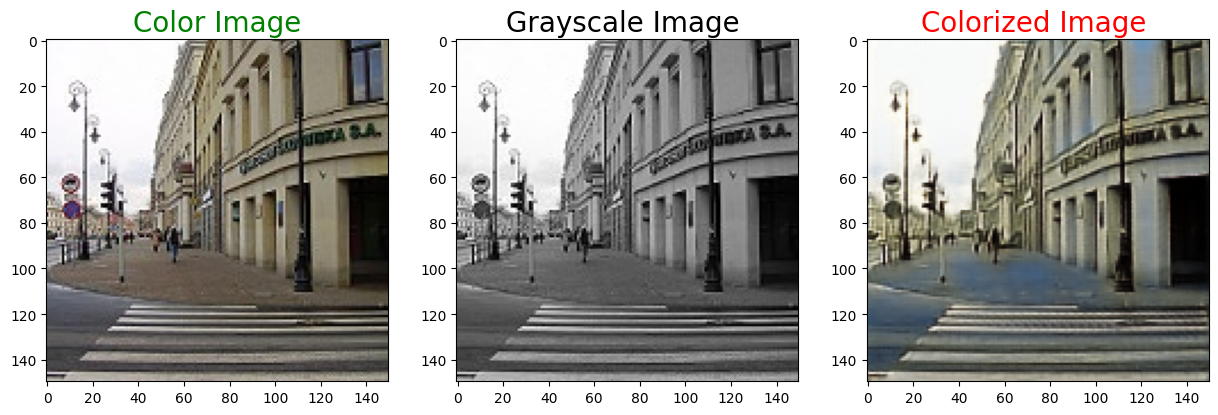

cuda:0


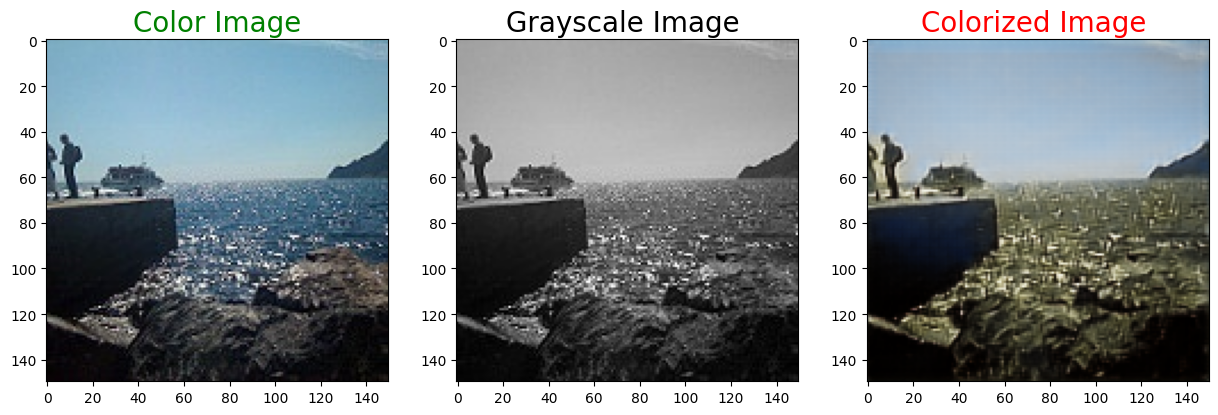

cuda:0


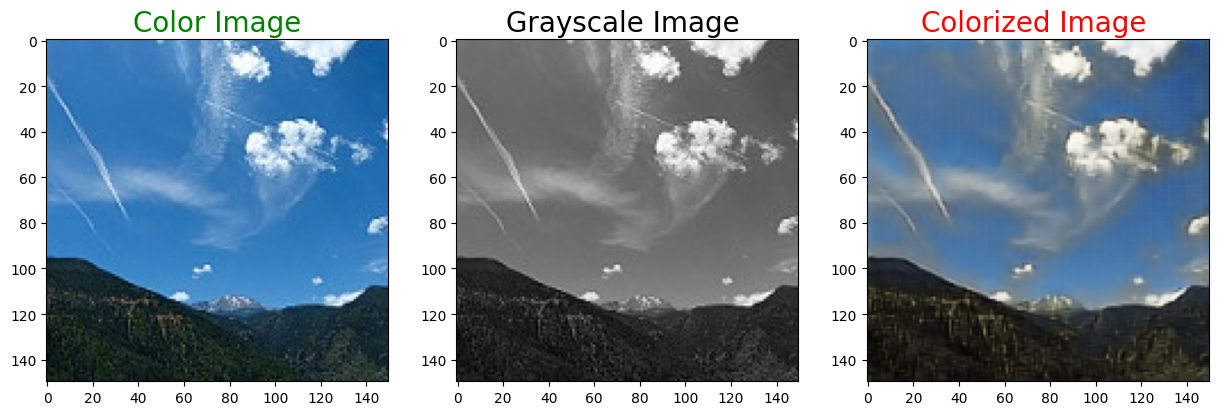

cuda:0


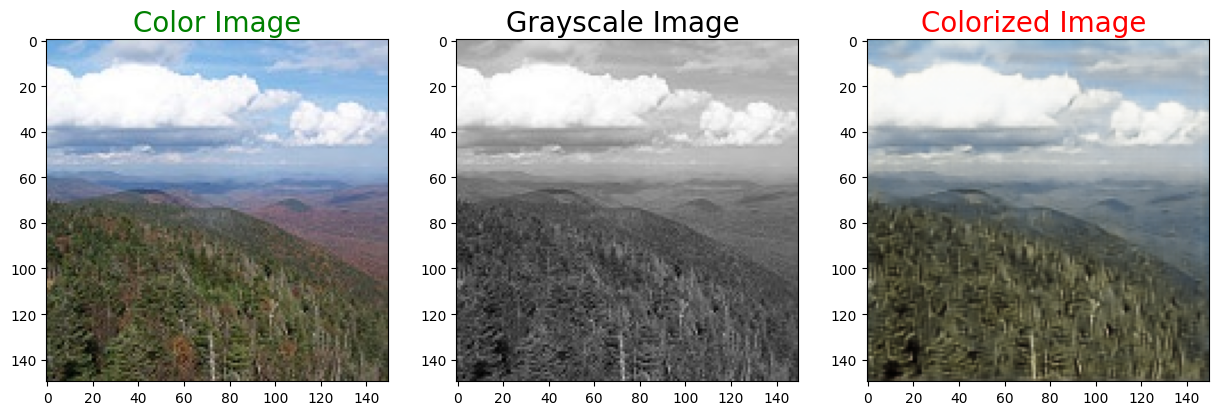

cuda:0


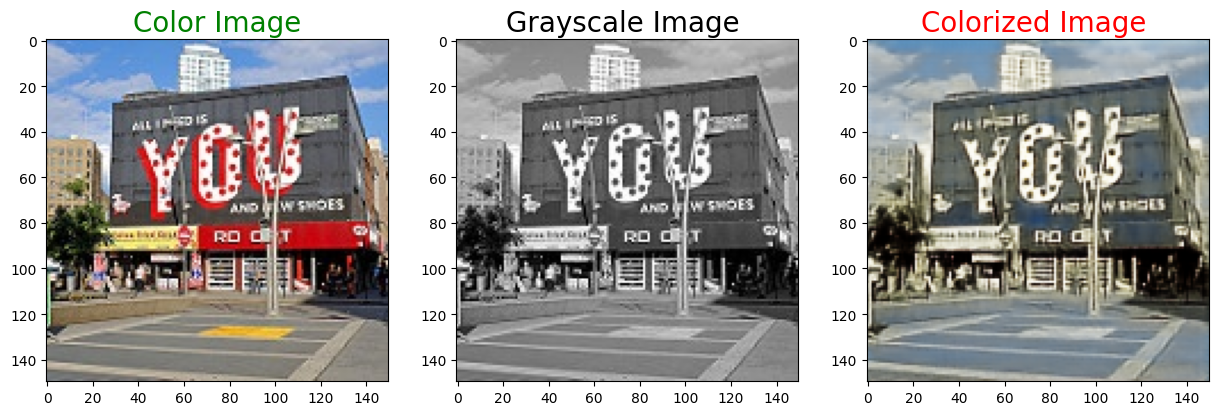

cuda:0


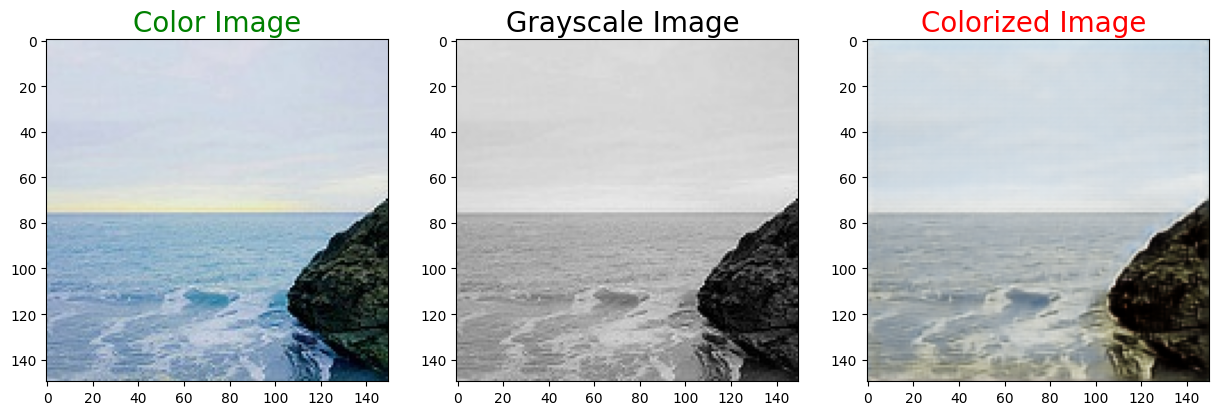

cuda:0


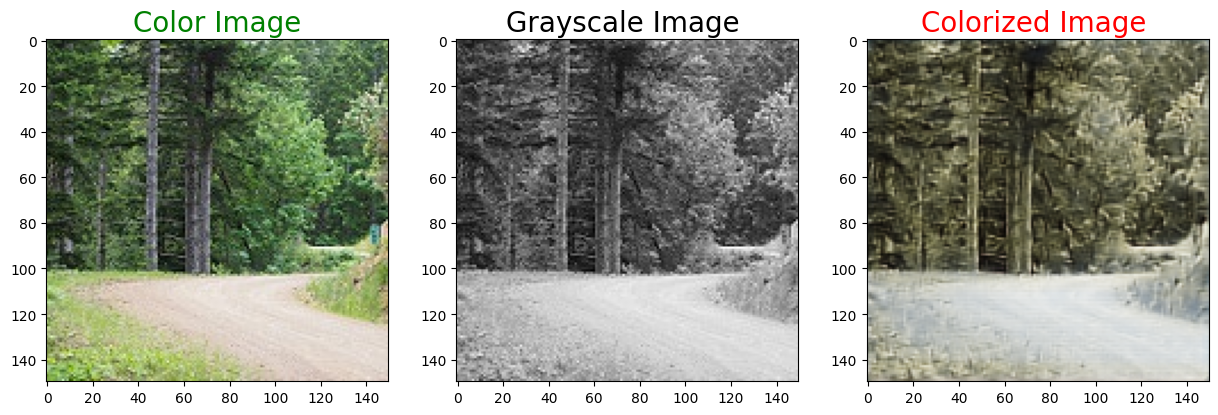

cuda:0


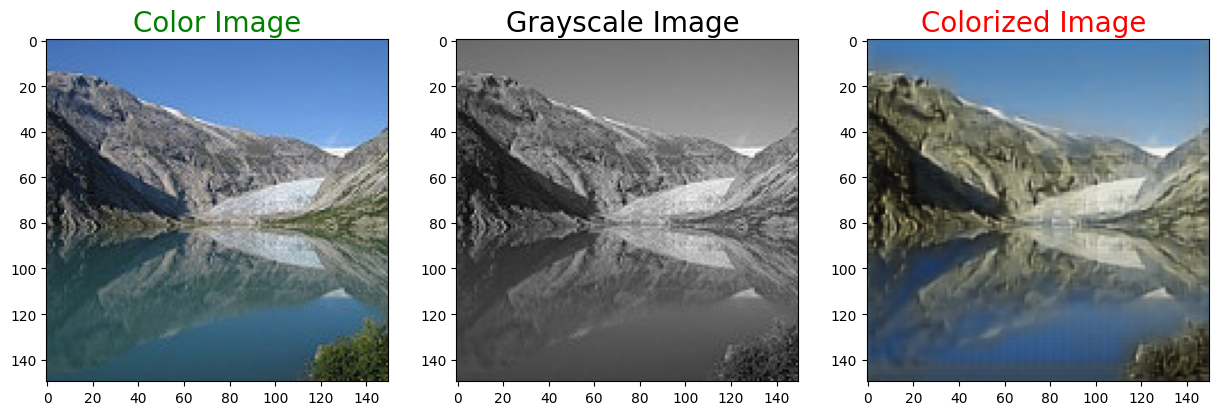

cuda:0


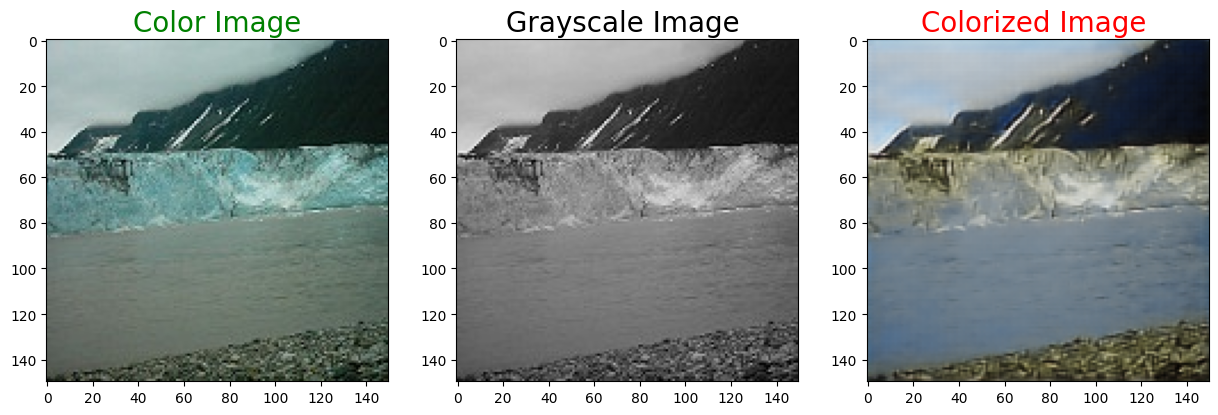

cuda:0


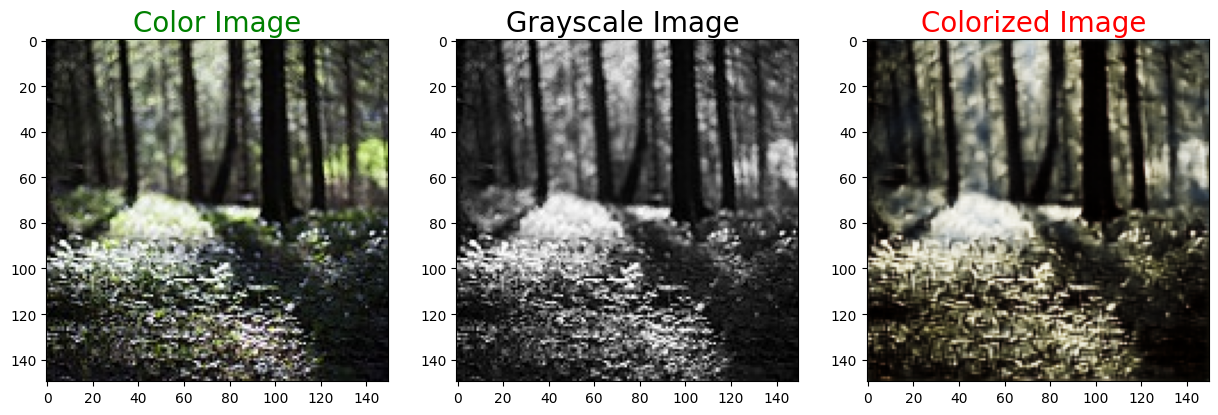

cuda:0


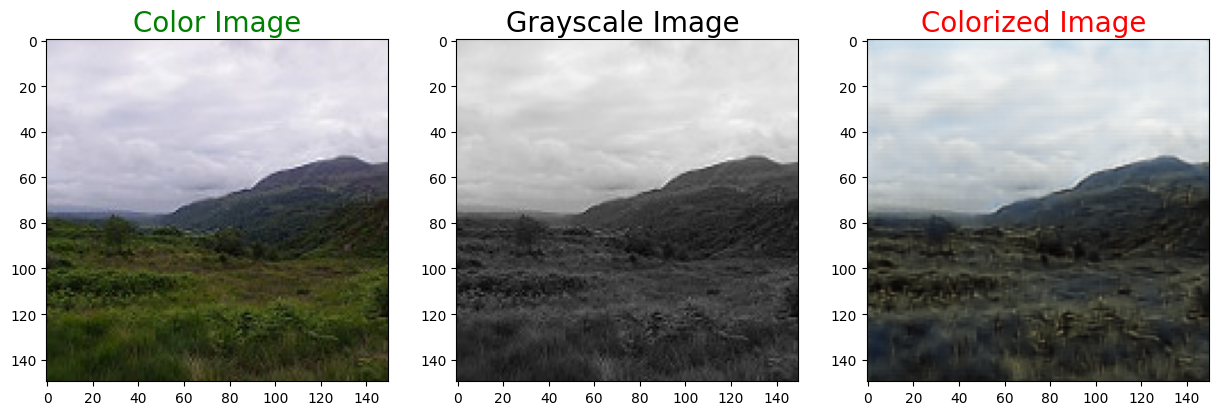

cuda:0


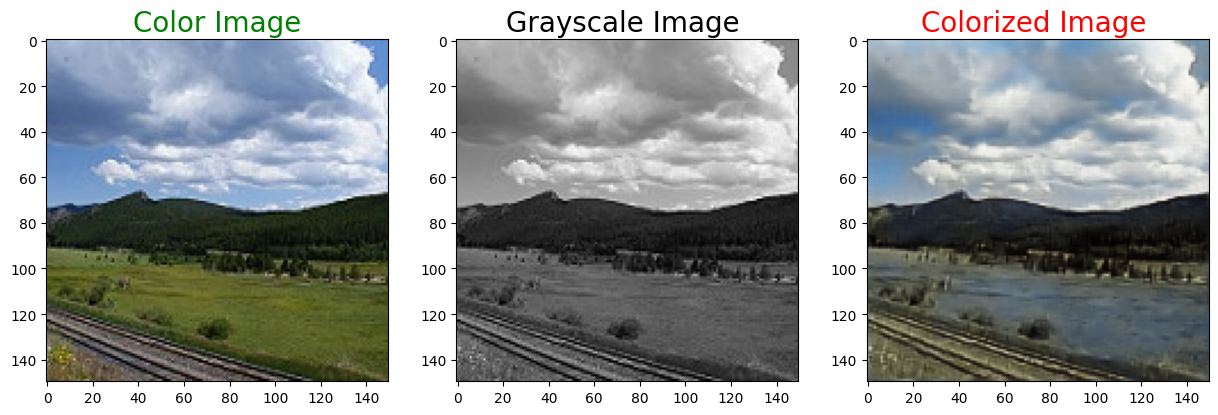

cuda:0


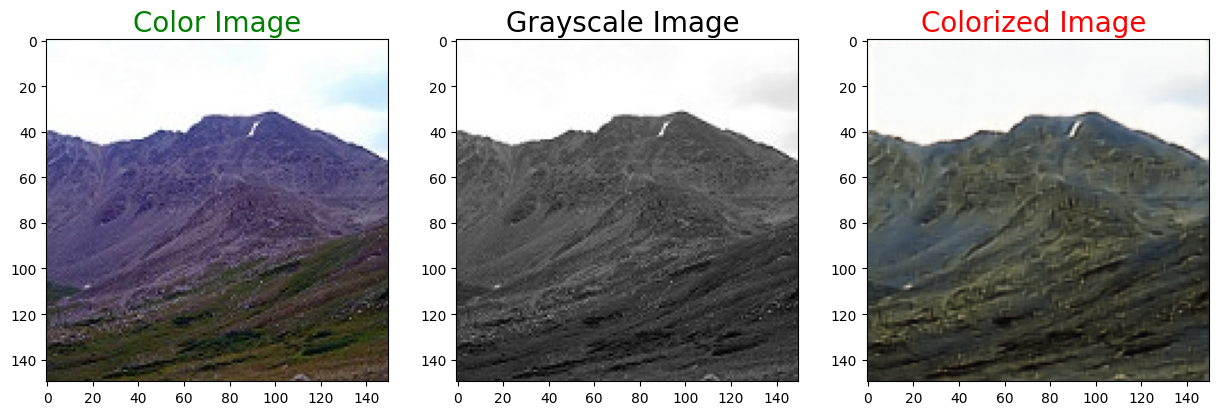

cuda:0


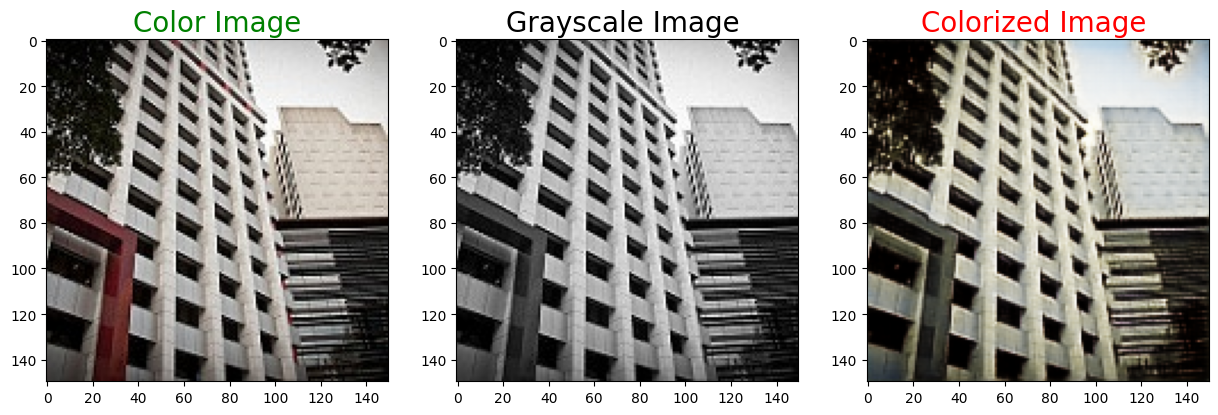

cuda:0


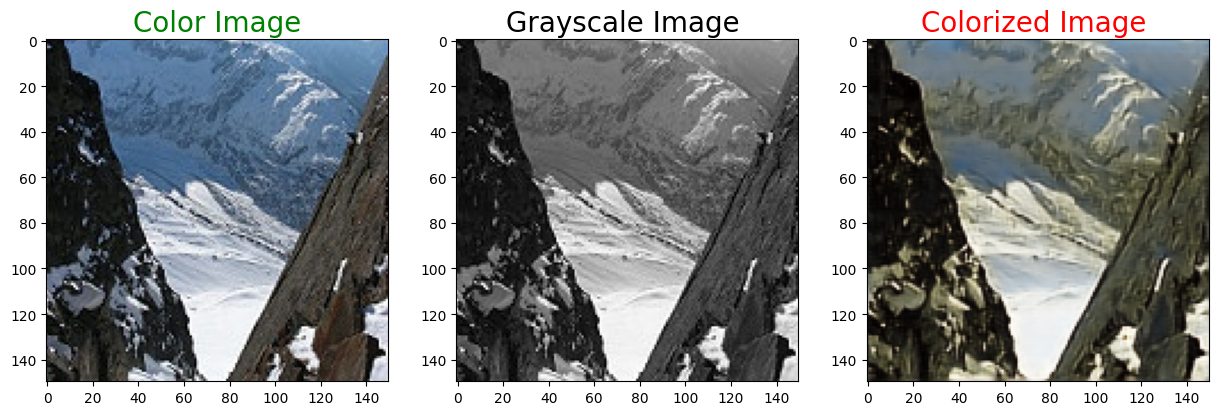

In [28]:
test_batch_size=15
test_dataloader = DataLoader(test_set, batch_size=test_batch_size, shuffle=True)

with torch.no_grad():
  for i, (inputs, targets) in enumerate(test_dataloader):
      inputs = inputs.to(device)#.reshape(-1,150*150)
      targets = targets.to(device)
      # Forward pass
      outputs = model(inputs)

      if(i%200==0):
        for j in range(len(inputs)):
          plot_images(targets[j],inputs[j],outputs[j])